In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

In [2]:
df = pd.read_csv("C:/AI_Dataset/car_evaluation.csv")
df.head()

,vhigh,vhigh.1,2,2.1,small,low,unacc
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [3]:
df.columns

Index(['vhigh', 'vhigh.1', '2', '2.1', 'small', 'low', 'unacc'], dtype='object')

In [4]:
df.isnull().sum()

vhigh      0
vhigh.1    0
2          0
2.1        0
small      0
low        0
unacc      0
dtype: int64

In [5]:
df['unacc'].value_counts()

unacc
unacc    1209
acc       384
good       69
vgood      65
Name: count, dtype: int64

In [6]:
columns = ['vhigh', 'vhigh.1', '2', '2.1', 'small', 'low','unacc']
label_encoders = {}
for column in columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

In [7]:
X = df.drop('unacc', axis=1).values
y = df['unacc'].values

In [8]:
# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1381, 6), (346, 6), (1381,), (346,))

In [10]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
class CarEvaluationDense(nn.Module):
    def __init__(self):
        super(CarEvaluationDense, self).__init__()
        self.fc1 = nn.Linear(6, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 4)  # 4 classes in the dataset
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### 모델, 손실 함수, 최적화 기법 정의

In [12]:
model = CarEvaluationDense()

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Variables to store loss and accuracy
train_losses = []
test_accuracies = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/20, Loss: 0.9948, Accuracy: 69.08%
Epoch 2/20, Loss: 0.7392, Accuracy: 69.08%
Epoch 3/20, Loss: 0.6689, Accuracy: 70.52%
Epoch 4/20, Loss: 0.6365, Accuracy: 71.97%
Epoch 5/20, Loss: 0.6028, Accuracy: 72.54%
Epoch 6/20, Loss: 0.5708, Accuracy: 73.99%
Epoch 7/20, Loss: 0.5171, Accuracy: 75.14%
Epoch 8/20, Loss: 0.4667, Accuracy: 78.03%
Epoch 9/20, Loss: 0.4039, Accuracy: 83.82%
Epoch 10/20, Loss: 0.3625, Accuracy: 83.24%
Epoch 11/20, Loss: 0.3315, Accuracy: 86.71%
Epoch 12/20, Loss: 0.2986, Accuracy: 85.26%
Epoch 13/20, Loss: 0.2785, Accuracy: 89.31%
Epoch 14/20, Loss: 0.2527, Accuracy: 89.02%
Epoch 15/20, Loss: 0.2297, Accuracy: 89.60%
Epoch 16/20, Loss: 0.2153, Accuracy: 92.49%
Epoch 17/20, Loss: 0.1968, Accuracy: 92.20%
Epoch 18/20, Loss: 0.1831, Accuracy: 93.64%
Epoch 19/20, Loss: 0.1700, Accuracy: 93.64%
Epoch 20/20, Loss: 0.1567, Accuracy: 94.22%
Training complete.


In [14]:
# Evaluation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# Calculate specificity for each class
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[ 72   3   2   0]
 [  3   7   0   4]
 [  7   0 232   0]
 [  1   0   0  15]]
F1 Score: 0.94
Precision: 0.94
Recall: 0.94
Specificity: 0.98


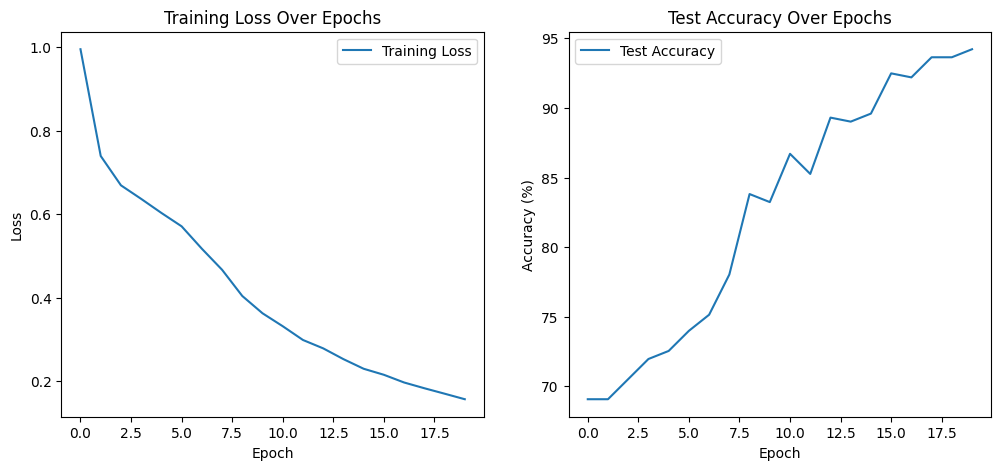

In [15]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()
